## Condensate growth in 2D projected GPE
This notebook gives an example of usage for the 2D projected GPE.  

Starting from a random initial condition, the low energy c-field evolves in the presence of a high energy reservoir able to exchange particles and energy with the c-field. This exchange is modelled using the damped Projected Gross-Pitaevskii equation, an equation of motion with no noise terms. 

The final states after long time evolution are ground states of the Projected GPE with chemical potential $\mu$ matching that of the reservoir. 

Tempeature is not a meaningful exteral parameter of the model: in the absence of a thermal bath, the evolution internally thermalises the c-field.

In [1]:
using Revise, ProjectedGPE

INFO: Recompiling stale cache file /Users/abradley/.julia/lib/v0.6/ProjectedGPE.ji for module ProjectedGPE.


In [3]:
function timeevolution2()
siminfo = Params()
#== start parameters ==#
#fundamental constants/units
  ħ = 1.0545718e-34
  kB = 1.38064852e-23
  amu = 1.660339040e-27
  a₀ = 5.29e-11
#Rb87 mass and scattering length
  m = 86.909180527*amu
  as = 100*a₀
#trap frequencies
  ωx = 2π
  ωy = 4ωx
  ωz = 0.
#choice of time, length, energy units
  t0 = 1.0/ωy
  x0 = sqrt(ħ*t0/m)
  E0 = ħ/t0
#interactions
  #g  = (4*pi*ħ^2*as/m)*x0^3/E0 #dimensionless 3D
  g = 0.1 #test 2D
#damping parameters (dimensionless)
  γ  = 0.05
  ℳ = 0.0
#chemical potential (dimensionless)
  μ  = 12.0
#time evolution parameters
  ti = 0.0
  tf = 1.0/γ  #evolve for 2 damping times
  Nt = 50
  t = collect(linspace(ti,tf,Nt))
  dt = 0.01π/μ #integrate step size [ - should have dt ≪ 2π/μ]
#== end parameters ==#    
    
@pack siminfo = ωx,ωy,ωz,γ,ℳ,g,t0,x0,E0,μ,ti,tf,Nt,t,dt

#Initialize CField (dimensionless)
  basis = "Hermite"
  ecut = 30*ħ*ωy/E0 
  Ω = [ωx; ωy]*t0
  cinfo = makecinfo(ecut,Ω,basis)
  @unpack en,P,M = cinfo ;Mx,My = M
  x,wx,Tx,y,wy,Ty = makealltrans(M,4,Ω)
  W = wx.*wy'
  
#test transform
  c0   = randn(Mx,My)+im*randn(Mx,My); c0=P.*c0
  ψ0   = Tx*c0*Ty' #initial condition
  ψ    = Tx*c0*Ty' #a field to write to in place 

#PGPE time evolution
#out of place
function nlin(c)
    ψ = Tx*c*Ty'
    Tx'*(W.*abs2.(ψ).*ψ)*Ty
end

#in place
function nlin!(dc,c)
    ψ = Tx*c*Ty'
    dc.= Tx'*(W.*abs2.(ψ).*ψ)*Ty
end

#dPGPE in reservoir "frame"
#out of place
function Lgp(c,p,t)
     return P.*(-im*(1-im*γ)*((en - μ).*c .+ g*nlin(c)))
end

#in place
function Lgp!(dc,c,p,t)
    nlin!(dc,c)
    dc .= P.*(-im*(1-im*γ)*((en - μ).*c .+ g*dc))
end

c0    = P.*(randn(Mx,My) + im*randn(Mx,My)) #create random initial state
tspan = (t[1],t[end])
prob = ODEProblem(Lgp!,c0,tspan)
alg =    DP5()
println("Started evolution ...")
@time sol = solve(prob,alg,dt=dt,saveat=t);
println("... Finished.")
return siminfo,cinfo,sol
end


timeevolution2 (generic function with 1 method)

In [4]:
siminfo,cinfo,sol = timeevolution2()

Started evolution ...
 13.403971 seconds (3.46 M allocations: 2.322 GiB, 4.52% gc time)
... Finished.


(ProjectedGPE.Params
  ħ: Float64 1.0545718e-34
  kB: Float64 1.38064852e-23
  amu: Float64 1.66033904e-27
  a₀: Float64 5.29e-11
  m: Float64 1.4429870536338587e-25
  as: Float64 5.29e-9
  ωx: Float64 6.283185307179586
  ωy: Float64 25.132741228718345
  ωz: Float64 0.0
  t0: Float64 0.039788735772973836
  x0: Float64 5.392459968224566e-6
  E0: Float64 2.6504280156503715e-33
  g: Float64 0.1
  γ: Float64 0.05
  ℳ: Float64 0.0
  μ: Float64 12.0
  ti: Float64 0.0
  tf: Float64 20.0
  Nt: Int64 50
  t: Array{Float64}((50,)) [0.0, 0.408163, 0.816327, 1.22449, 1.63265, 2.04082, 2.44898, 2.85714, 3.26531, 3.67347  …  16.3265, 16.7347, 17.1429, 17.551, 17.9592, 18.3673, 18.7755, 19.1837, 19.5918, 20.0]
  dt: Float64 0.0026179938779914945
, ProjectedGPE.CInfo
  γ: Float64 0.0001
  ℳ: Float64 0.0
  g: Float64 0.1
  μ: Float64 12.0
  basis: String "Hermite"
  Ω: Array{Float64}((2,)) [0.25, 1.0]
  ecut: Float64 29.999999999999996
  e0: Float64 0.625
  Mmax: Int64 118
  Mult: Int64 1800
  M: Array

In [6]:
#plot solution for 2D
## Transform to cartesian grid
@unpack ħ,m,ωx,ωy,ωz,γ,ℳ,g,x0,t0,E0,μ,ti,tf,Nt,t,dt = siminfo
@unpack M,Ω,ecut,P,en = cinfo; Mx,My = M;

Interact.Options{:SelectionSlider,Any}(1: "input" = 25 Any , "i", 25, "25", 25, Interact.OptionDict(DataStructures.OrderedDict{Any,Any}("1"=>1,"2"=>2,"3"=>3,"4"=>4,"5"=>5,"6"=>6,"7"=>7,"8"=>8,"9"=>9,"10"=>10…), Dict{Any,Any}(Pair{Any,Any}(2, "2"),Pair{Any,Any}(11, "11"),Pair{Any,Any}(39, "39"),Pair{Any,Any}(46, "46"),Pair{Any,Any}(25, "25"),Pair{Any,Any}(42, "42"),Pair{Any,Any}(29, "29"),Pair{Any,Any}(8, "8"),Pair{Any,Any}(20, "20"),Pair{Any,Any}(14, "14")…)), Any[], Any[], true, "horizontal")

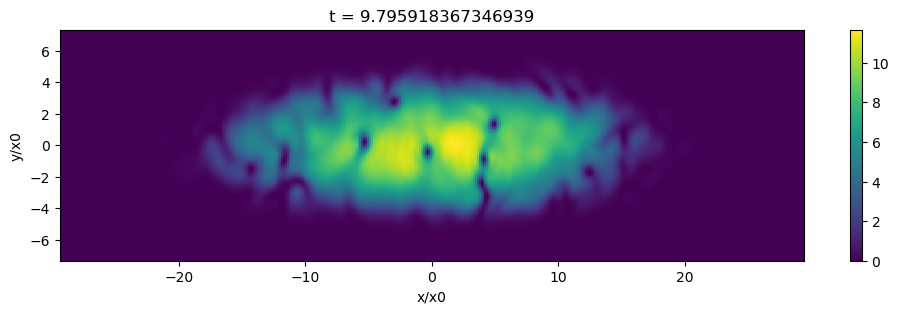

In [7]:
using Interact, PyPlot

#lets be explicit about units:
Rx = sqrt(2μ*E0/m/ωx^2) 
Ry = sqrt(2μ*E0/m/ωy^2) 
yMax=1.5Ry
xMax=1.5Rx

Nx = 400
Ny = Nx
x = collect(linspace(-xMax,xMax,Nx))
y = collect(linspace(-yMax,yMax,Ny))
Tx = eigmat(Mx,x/x0,ω=ωx/ωy)
Ty = eigmat(My,y/x0,ω=ωy/ωy); 
#θ = unwrap(angle(ψ));

#Plot
f=figure(figsize=(12,3))
@manipulate for i in 1:length(t) withfig(f,clear=true) do
    ψ = Tx*sol[i]*Ty';
    pcolormesh(x/x0,y/x0,g*abs2.(ψ'))
    xlabel("x/x0")
    ylabel("y/x0")
    title("t = $(t[i])")
    colorbar()
    end
end